In [ ]:
!unzip dataset.zip

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = 'dataset/'

# Generate training and validation datasets from image directories
train_dataset = image_dataset_from_directory(directory,
                                             shuffle = True,
                                             batch_size = BATCH_SIZE,
                                             image_size = IMG_SIZE,
                                             validation_split = 0.2,
                                             subset = 'training',
                                             seed = 42)
validation_dataset = image_dataset_from_directory(directory,
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZE,
                                                  image_size = IMG_SIZE,
                                                  validation_split = 0.2,
                                                  subset = 'validation',
                                                  seed = 42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


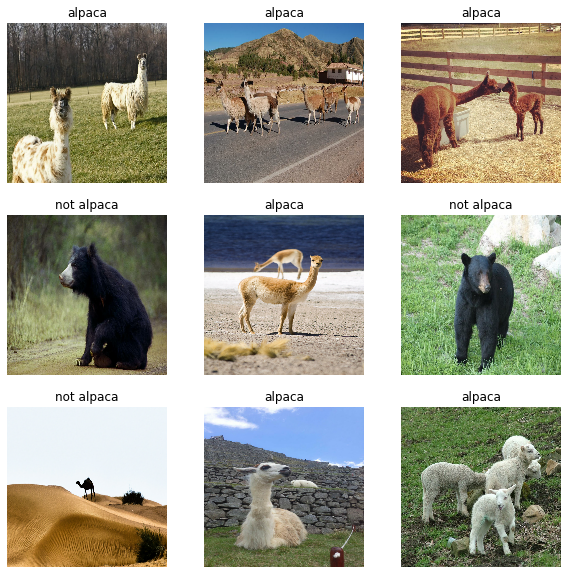

In [3]:
import matplotlib.pyplot as plt

# Visualize some of the images from the training set
class_names = train_dataset.class_names         # Get class names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):    # Take 1 batch of the training set
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

# Data preprocessing and augmentation

In [4]:
import tensorflow as tf

# Configuring prefetch - to allow input batches to be processed on CPU while GPU is being used for training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)

In [5]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

# Implement image augmentation method
def data_augmenter():
  '''
  Create data augmenter using Sequential API

  Arguments:
  None

  Returns:
  data_augmentation -- tf.keras.Sequential object, contains image augmentation layers
  '''

  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))

  return data_augmentation

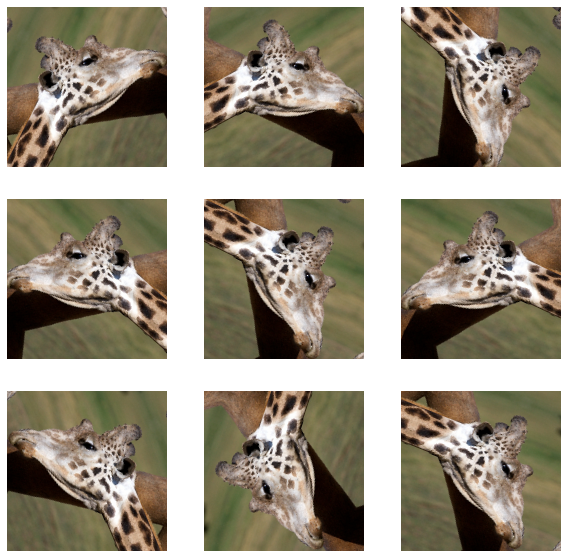

In [6]:
# Visualize how an image from training set has been augmented 
data_augmentation = data_augmenter()

plt.figure(figsize=(10,10))

for images, _ in train_dataset.take(1):         # Take 1 batch of the training set
  first_img = images[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_img = data_augmentation(tf.expand_dims(first_img, axis = 0))    # Apply augmentation
    plt.imshow(augmented_img[0] / 255)
    plt.axis('off')

In [7]:
# Because MobileNet was trained on the normalized value [-1, 1], therefore we have to normalize our input on that range as well, using mobilenet_v2.preprocess_input
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Load the pretrained MobileNet v2 model

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)         # Add the channels dimension - the shape is now (160, 160, 3), before it was (160, 160)
model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                          include_top = True,             # Keep the original output layer
                                          weights = 'imagenet')           # Load the weights that were trained on the ImageNet dataset

14548992/14536120 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [10]:
# Test the model's performance without fine-tuning
image_batch, label_batch = next(iter(train_dataset))
image_var = tf.Variable(image_batch)
preds = model(image_var)

# Decode the model's output
tf.keras.applications.mobilenet_v2.decode_predictions(preds.numpy(), top = 3)       # Print top 3 probabilities in 1000 classes 

49152/35363 [=========================================] - 0s 0us/step


[[('n04589890', 'window_screen', 0.4258222),
  ('n02708093', 'analog_clock', 0.09275633),
  ('n02098286', 'West_Highland_white_terrier', 0.030293467)],
 [('n04589890', 'window_screen', 0.23985828),
  ('n03887697', 'paper_towel', 0.14802735),
  ('n04525038', 'velvet', 0.09973316)],
 [('n04589890', 'window_screen', 0.74494636),
  ('n03598930', 'jigsaw_puzzle', 0.021948932),
  ('n02098286', 'West_Highland_white_terrier', 0.013677239)],
 [('n04589890', 'window_screen', 0.33546057),
  ('n03530642', 'honeycomb', 0.076289885),
  ('n02708093', 'analog_clock', 0.03164358)],
 [('n04589890', 'window_screen', 0.27327254),
  ('n03733281', 'maze', 0.08847101),
  ('n03598930', 'jigsaw_puzzle', 0.045661)],
 [('n04589890', 'window_screen', 0.67452717),
  ('n03530642', 'honeycomb', 0.076598816),
  ('n02708093', 'analog_clock', 0.05578718)],
 [('n04589890', 'window_screen', 0.79128563),
  ('n04209239', 'shower_curtain', 0.09241652),
  ('n04332243', 'strainer', 0.014148705)],
 [('n04589890', 'window_scree

# Fine-tune the MobileNet v2 model

In [11]:
# Load the pretrained model without the output layer
model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                          include_top = False,            # Exclude the output layer -- by definition, the 'top' layer in MobileNet is GlobalAveragePooling + Dense layer
                                          weights = 'imagenet')           # Load the weights that were trained on the ImageNet dataset

9420800/9406464 [==============================] - 0s 0us/step


In [12]:
# There are 154 layers in MobileNet v2, we will freeze the first 120 layers and retrain the last 34 layers
print(f'Number of layers in the pretrained MobileNet V2 model: {len(model.layers)} layers')

# First, enable training for all layers
model.trainable = True

# Then, freeze the first 120 layers
fine_tune_at = 120    
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the pretrained MobileNet V2 model: 154 layers


In [13]:
# Now we fine-tune the mode: replace the output layer and re-train the last few layers of the model for transfer learning purposes

import tensorflow.keras.layers as tfl

# Create input layer
inputs = tf.keras.Input(shape = IMG_SHAPE)

# Apply data augmentation to the inputs
x = data_augmentation(inputs)

# Data preprocessing using the same weights the model was trained on
x = preprocess_input(x)

# Set training to False to avoid keeping track of statistics in the batch norm layer
x = model(x, training = False)

# Because we excluded the 'top' layer (GlobalAveragePooling + Dense), so now we have to replace it by the custom one
x = tfl.GlobalAveragePooling2D()(x)         # Average pooling to summarize the info in each channel
x = tfl.Dropout(0.2)(x)                     # Dropout to avoid overfitting
outputs = tfl.Dense(units = 1)(x)

# Create the fine-tuned model
finetuned_model = tf.keras.Model(inputs = inputs, outputs = outputs)

In [14]:
# Compile the model
finetuned_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                        loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                        metrics = ['accuracy'])

In [15]:
# Implement callback to stop training early
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('accuracy') > 0.98:
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True

In [16]:
# Train the model
callbacks = myCallback()
history = finetuned_model.fit(train_dataset, validation_data = validation_dataset, epochs = 20, callbacks = [callbacks])

Epoch 1/20
9/9 [==============================] - 14s 572ms/step - loss: 0.6644 - accuracy: 0.5992 - val_loss: 0.3162 - val_accuracy: 0.8154
Epoch 2/20
9/9 [==============================] - 3s 131ms/step - loss: 0.3728 - accuracy: 0.8015 - val_loss: 0.2056 - val_accuracy: 0.9385
Epoch 3/20
9/9 [==============================] - 3s 128ms/step - loss: 0.3384 - accuracy: 0.8359 - val_loss: 0.2292 - val_accuracy: 0.8769
Epoch 4/20
9/9 [==============================] - 3s 128ms/step - loss: 0.2797 - accuracy: 0.8511 - val_loss: 0.2052 - val_accuracy: 0.8769
Epoch 5/20
9/9 [==============================] - 3s 126ms/step - loss: 0.2029 - accuracy: 0.8969 - val_loss: 0.0972 - val_accuracy: 0.9846
Epoch 6/20
9/9 [==============================] - 3s 127ms/step - loss: 0.1425 - accuracy: 0.9313 - val_loss: 0.1779 - val_accuracy: 0.9538
Epoch 7/20
9/9 [==============================] - 3s 127ms/step - loss: 0.2142 - accuracy: 0.9046 - val_loss: 0.1045 - val_accuracy: 0.9846
Epoch 8/20
9/9 [===

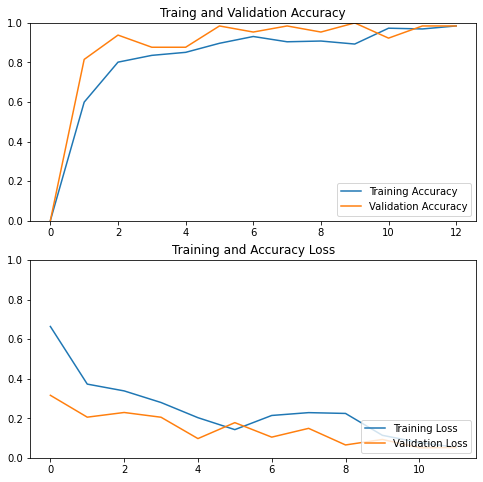

In [17]:
# Plot training and validation accuracy

# Get the results
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel = ('Accuracy')
plt.xlabel = ('Epoch')
plt.ylim([0, 1.0])
plt.title('Traing and Validation Accuracy')

# Plot training and validation loss
plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.ylabel = 'Cross Entropy Loss'
plt.xlabel = 'Epoch'
plt.ylim([0, 1.0])
plt.title('Training and Accuracy Loss')
plt.show()

In [63]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Test model with an unseen image
x = image.load_img('test_images/not_alpaca3.jpg', target_size = IMG_SIZE)
x = image.img_to_array(x)
x = np.expand_dims(x, axis = 0)
pred = finetuned_model.predict(x)
print('Alpaca' if pred < 0 else 'Not Alpaca')

Not Alpaca
